# ADMET

# Lead compound defination

``A lead compound is a chemical compound that has pharmacological or biological activity likely to be therapeutically useful, but may nevertheless have suboptimal structure that requires modification to fit better to the target; lead drugs offer the prospect of being followed by back-up compounds.``

source: [wiki](https://en.wikipedia.org/wiki/Lead_compound#cite_note-Early_Drug_Discovery-1)

# ADMET criteria

__Lipinski's Rule of 5 /Pfizer's rule of five__

- Molecular weight (MWT) <= 500 Da
- Number of hydrogen bond acceptors (HBAs) <= 10
- Number of hydrogen bond donors (HBD) <= 5 
- Calculated LogP (octanol-water coefficient) <= 5


# Filters in medicinal chemistry

1. Lipinski Rule of 5

2. Ghose Filter

3. Veber Filter

4. Rule of 3 Filter

5. REOS Filter

6. Drug-like Filter (QED)

__Lipinski__:

    Moleculer Weight <= 500
    LogP <= 5
    H-Bond Donor Count <= 5
    H-Bond Acceptor Count <= 10
    
__Ghose__:

    Molecular weight between 160 and 480
    LogP between -0.4 and +5.6
    Atom count between 20 and 70
    Molar refractivity between 40 and 130

__Veber__:

    Rotatable bonds <= 10
    Topological polar surface area <= 140

__REOS__:

    Molecular weight between 200 and 500
    LogP between -5.0 and +5.0
    H-bond donor count between 0 and 5
    H-bond acceptor count between 0 and 10
    Formal charge between -2 and +2
    Rotatable bond count between 0 and 8
    Heavy atom count between 15 and 50

__Rule of 3__:

    Molecular weight <= 300
    LogP <= 3
    H-bond donor <= 3
    H-bond acceptor count <= 3
    Rotatable bond count <= 3

__Drug-Like (QED)__:

    mass < 400
    ring count > 0
    rotatable bond count < 5
    h-bond donor count <= 5
    h-bond acceptor count <= 10
    logP < 5
    
*Ref:* https://sharifsuliman1.medium.com/understanding-drug-likeness-filters-with-rdkit-and-exploring-the-withdrawn-database-ebd6b8b2921e

# In this work we will test Lipinski's Ro5

In [1]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

from rdkit.Chem import rdFMCS

In [2]:
molecules = pd.read_csv("data/BTK_compounds.csv", index_col=0)
print(molecules.shape)
molecules.head()

(2750, 5)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL4113670,0.058,nM,C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...,10.236572
1,CHEMBL4648442,0.070,nM,C#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)...,10.154902
2,CHEMBL4113445,0.075,nM,Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...,10.124939
3,CHEMBL4240879,0.079,nM,C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...,10.102373
4,CHEMBL4109744,0.081,nM,Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...,10.091515


In [3]:
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL4113670,0.058,nM,C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...,10.236572,
1,CHEMBL4648442,0.070,nM,C#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)...,10.154902,
2,CHEMBL4113445,0.075,nM,Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...,10.124939,
3,CHEMBL4240879,0.079,nM,C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...,10.102373,
4,CHEMBL4109744,0.081,nM,Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...,10.091515,

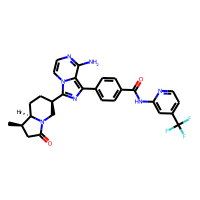
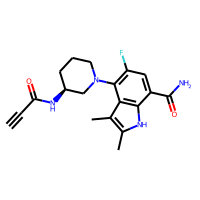
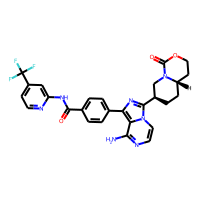
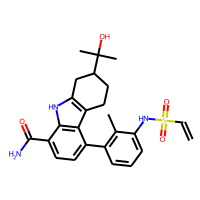
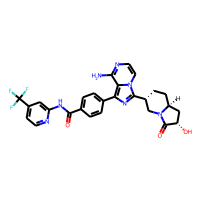

In [4]:
molecules.head()

# Alternate way of adding ROMol object


# function

# Ref: [Teachopencadd](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T002_compound_adme/talktorial.ipynb) 

In [5]:

def check_ro5(smiles):
    
    # Making sure it's canonical SMILES
    cano_smi = Chem.CanonSmiles(smiles)
    
    ## Molecule from SMILES
    molecule = Chem.MolFromSmiles(cano_smi)
    
    ## RO5 properties
    mw = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)

    conditions = [mw <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    
    ro5_fulfilled = sum(conditions) >= 3
    
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [mw, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )


In [6]:

ro5_properties = molecules["smiles"].apply(check_ro5)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,549.210008,7,2,4.75900,True
1,356.164854,3,3,1.74094,True
2,551.189272,8,2,4.73290,True
3,467.187877,4,4,4.00322,True
4,551.189272,8,3,3.48380,True


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL4113670,0.058,nM,C[C@@H]1CC(=O)N2C[C@H](c3nc(-c4ccc(C(=O)Nc5cc(...,10.236572,,549.210008,7,2,4.75900,True
1,CHEMBL4648442,0.070,nM,C#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)...,10.154902,,356.164854,3,3,1.74094,True
2,CHEMBL4113445,0.075,nM,Nc1nccn2c([C@@H]3CC[C@H]4CCOC(=O)N4C3)nc(-c3cc...,10.124939,,551.189272,8,2,4.73290,True
3,CHEMBL4240879,0.079,nM,C=CS(=O)(=O)Nc1cccc(-c2ccc(C(N)=O)c3[nH]c4c(c2...,10.102373,,467.187877,4,4,4.00322,True
4,CHEMBL4109744,0.081,nM,Nc1nccn2c([C@@H]3CC[C@H]4C[C@H](O)C(=O)N4C3)nc...,10.091515,,551.189272,8,3,3.48380,True

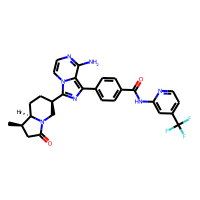
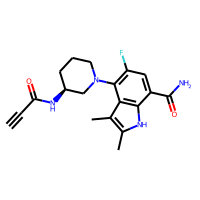
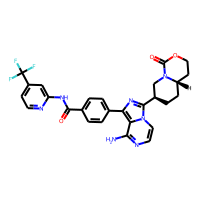
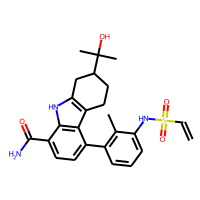
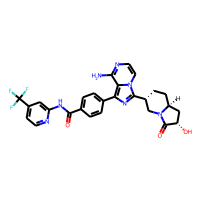

In [7]:
## catenating two dataframes
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

In [9]:
# Counting true and false entries

molecules.ro5_fulfilled.value_counts()

True     1940
False     810
Name: ro5_fulfilled, dtype: int64

In [10]:
df_ro5_failed = molecules.loc[molecules['ro5_fulfilled'] == False ]

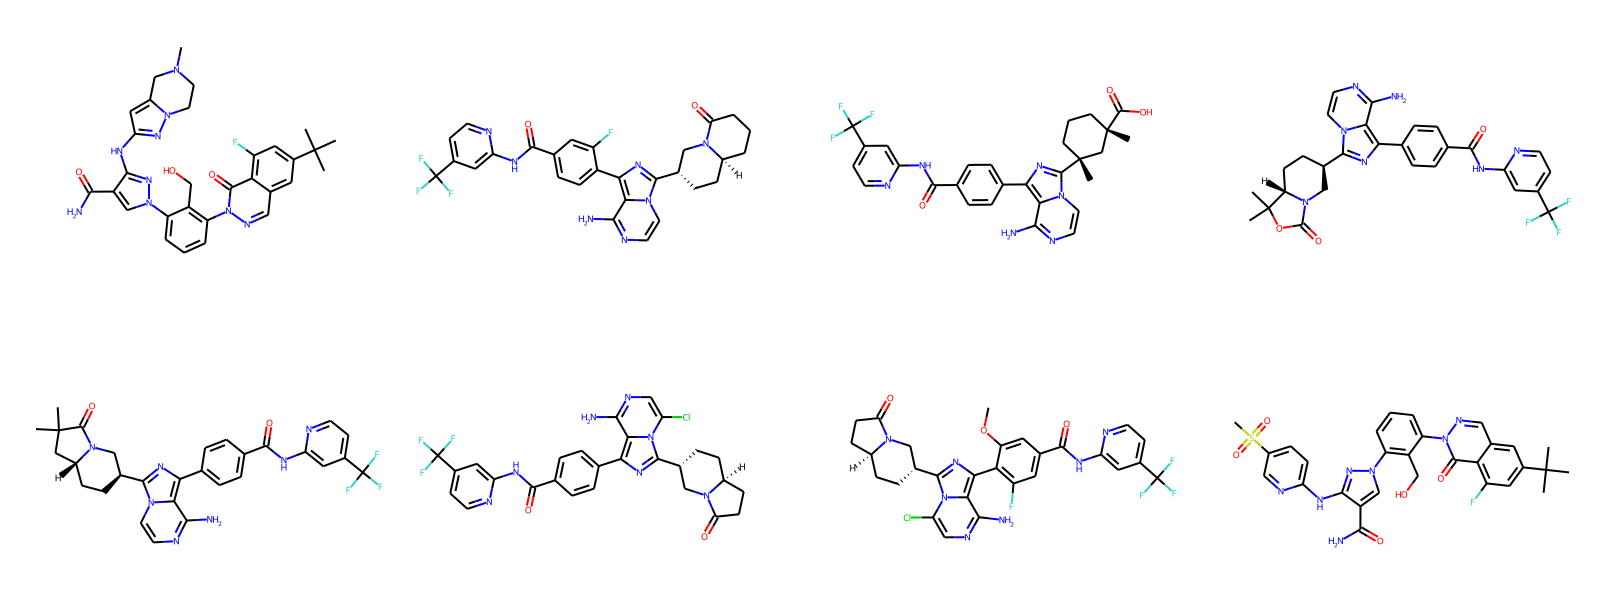

In [13]:
Draw.MolsToGridImage(df_ro5_failed.ROMol.head(8), molsPerRow=4, subImgSize=(400, 300))

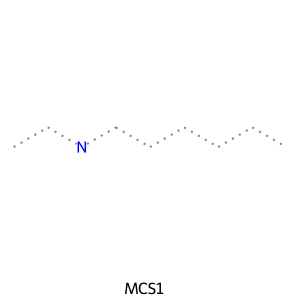

In [14]:
# Checking MCS of these RO5 failed structures

mcs1 = rdFMCS.FindMCS(list(df_ro5_failed.ROMol))
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

In [15]:
import seaborn as sns 

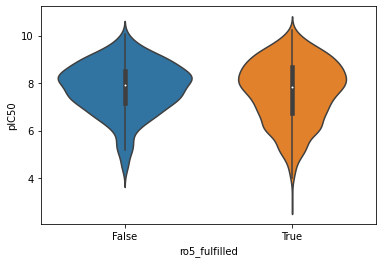

In [20]:
fig = sns.violinplot(x="ro5_fulfilled", y="pIC50", data=molecules)